## Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special, scipy.signal
import sys
import hickle, cPickle

sys.path.insert(0, '../../../getConversionFactors/')
sys.path.insert(0, '../../../csv/')

import plot_csv_support as pcs
import getConversionFactors as gcf
import getConversionFactors_poly as gcfp
import plotTemperatureToT as pttt
import ToTtoEnergy as tte

reload(pcs)
reload(gcf)
reload(gcfp)

<module 'getConversionFactors_poly' from '../../../getConversionFactors/getConversionFactors_poly.pyc'>

## Temperature Calibration Files

../../dpx_data/TemperatureToT_DPX22_6_109_Slot1_75keV.hck
../../dpx_data/TemperatureToT_DPX22_6_109_Slot1_125keV.hck


plotTemperatureToT.py:281: RuntimeWarning: overflow encountered in exp
  return np.where(x <= toff, offset1, np.where(x <= tmax, (Tmax - offset1)*(1 - np.exp(-tau1*(x - toff))) + offset1, (Tmax - offset2)*np.exp(-tau2*(x - tmax)) + offset2))
/usr/lib/python2.7/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/lib/python2.7/dist-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


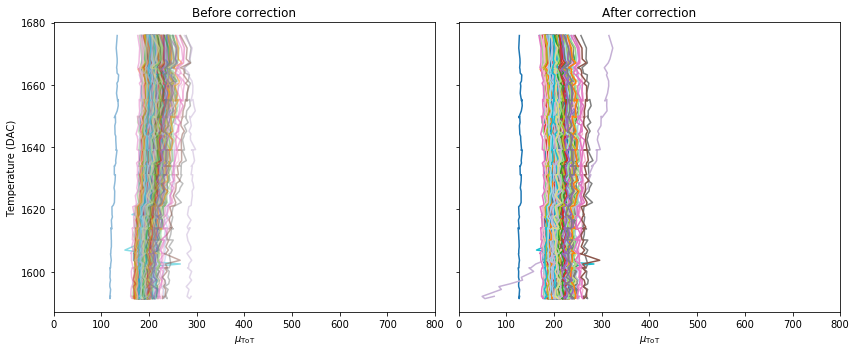

<Figure size 432x288 with 0 Axes>

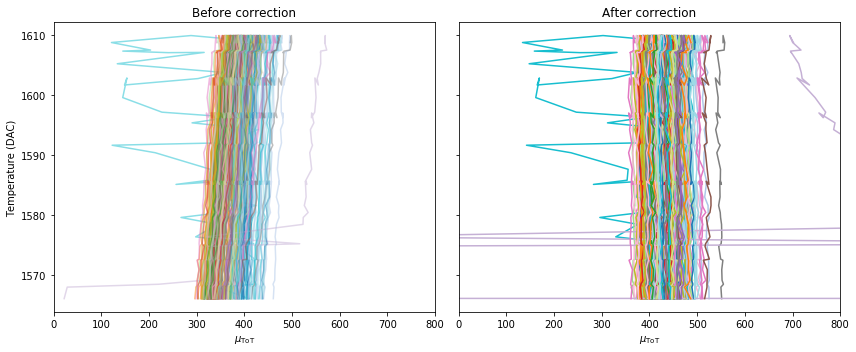

<Figure size 432x288 with 0 Axes>

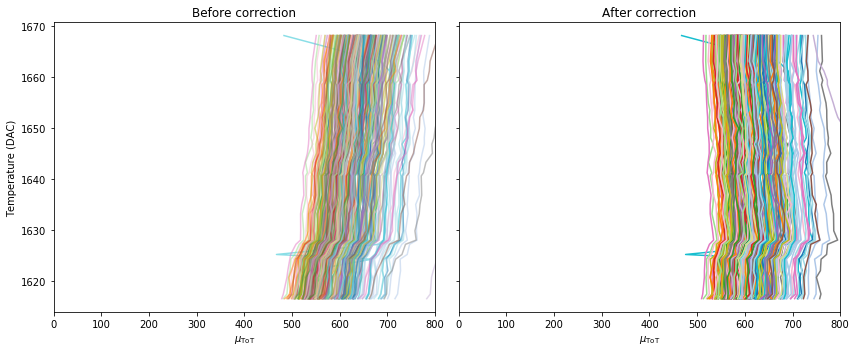

<Figure size 432x288 with 0 Axes>

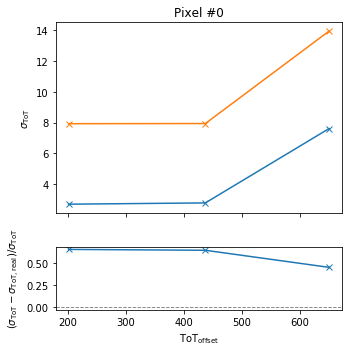

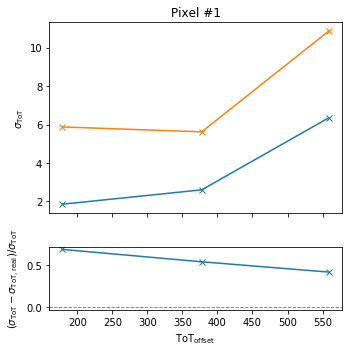

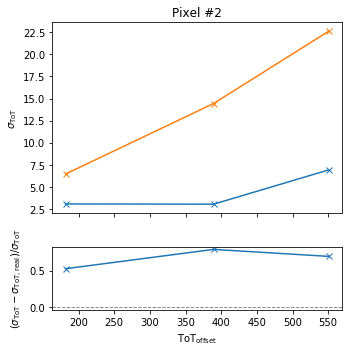

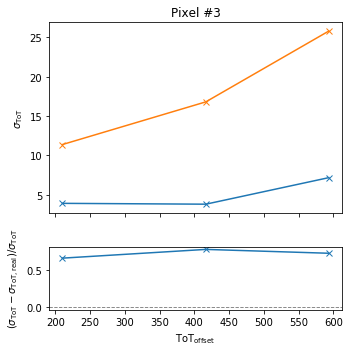

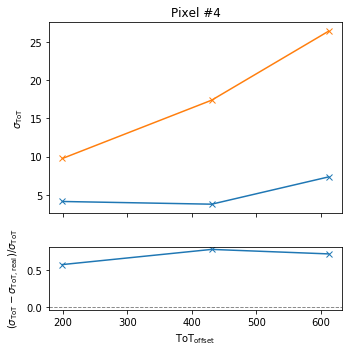

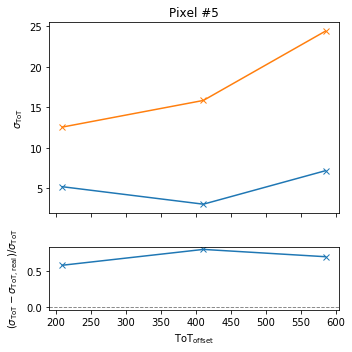

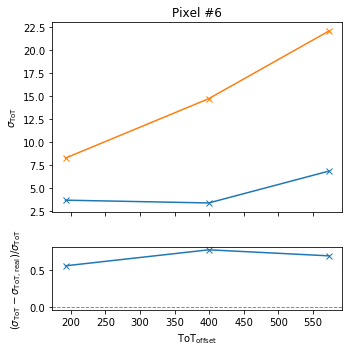

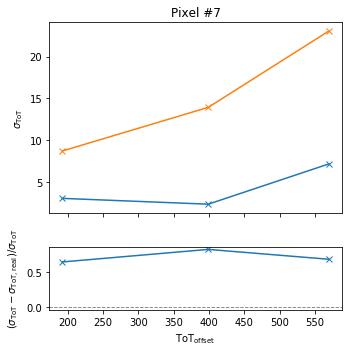

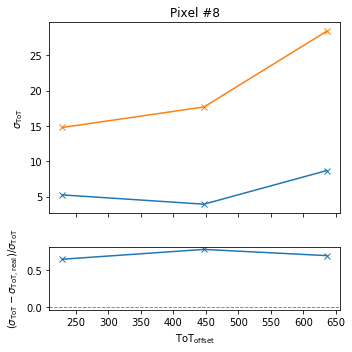

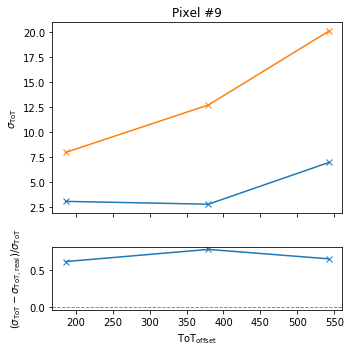

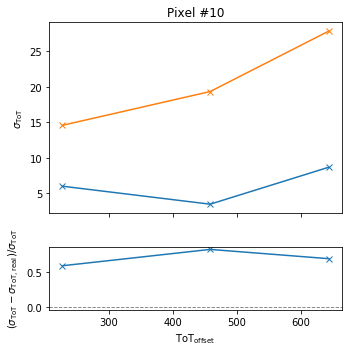

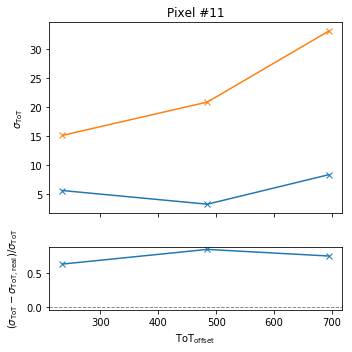

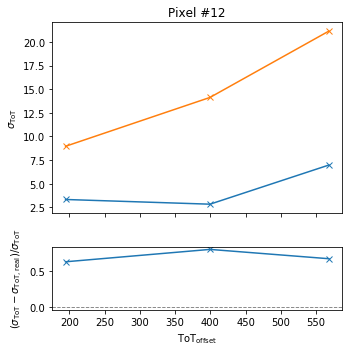

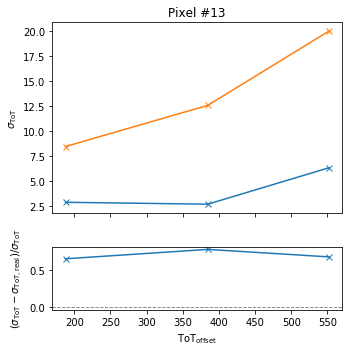

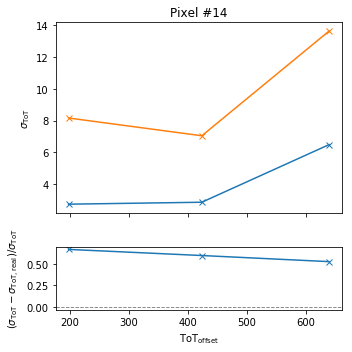

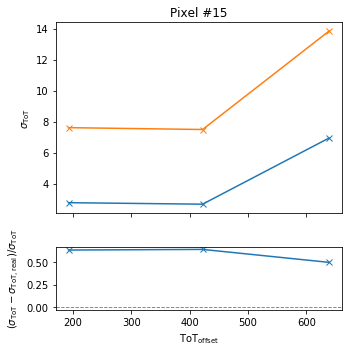

In [3]:
energyList = [25, 75, 125] # , 125]
infileList = ['../../dpx_data/TemperatureToT_DPX22_6_109_Slot1_%dkeV.hck' % energy for energy in energyList]

def combineFiles(infileList, energyList):
    # Get first file
    if infileList[0].endswith('.p'):
        d = cPickle.load(open(infileList[0], 'rb'))
    else:
        d = hickle.load(infileList[0])

    # Add energy column if needed
    if not 'energy' in d.keys():
        energy = energyList[0] * 1000
        d['energy'] = [energy]*len(d['time'])

    dim = min(len(d['energy']), len(d['ToT']), len(d['time']))
    for key in d.keys():
        d[key] = d[key][:dim]
        
    for idx, infile in enumerate(infileList[1:]):
        print infile
        if infileList[idx].endswith('.p'):
            d_ = cPickle.load(open(infile, 'rb'))
        else:
            d_ = hickle.load(infile)
                        
        if not 'energy' in d_.keys():
            energy = energyList[idx+1] * 1000
            d_['energy'] = [energy]*len(d_['time'])
            
        dim = min(len(d_['energy']), len(d_['ToT']), len(d_['time']))
        for key in d_.keys():
            d_[key] = d_[key][:dim]
            
        for key in d.keys():
            d[key] += list(d_[key])
            
    return d

temperatureDict = combineFiles(infileList, energyList)
roomTemp = 1640
outDict = pttt.plotTemperature(temperatureDict, offsettemp=1640, cuttemp=1520, plot=False, outdir='temperatureDPX22')
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')
slope, offset, Toffset = outDict['slope'], np.asarray(outDict['offset']), outDict['Toffset']

# hickle.dump(outDict, 'tempCalib_DPX109.hck')

## Bin Edges

In [4]:
binEdgesTh = {'vac': [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430],
        'sn': [32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430],
        'al': [12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]}

## Support Functions

In [5]:
def getNormalCounts(mu, sigma, a, b):
    return 0.5 * (scipy.special.erf((b - mu) / np.sqrt(2 * sigma**2)) - scipy.special.erf((a - mu) / np.sqrt(2 * sigma**2)))

def histMean(bins, hist):
    hist = np.nan_to_num(hist)
    bw = np.asarray(bins[:-1]) + 0.5 * np.diff(bins)
    mean = np.dot(bw, hist) / np.nansum(hist)
    return mean, np.sqrt(np.dot(hist/float(np.sum(hist)), np.square(np.asarray(bw) - mean)))

def ToTtoEnergy(data, params):
    pixelData = data
    # pixelData = pixelData[pixelData > 0]
    p = params
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']

    pixelDataEnergy = tte.ToTtoEnergy(pixelData, a, b, c, t, h, k)
    # pixelDataEnergy = pixelDataEnergy[np.logical_and(pixelDataEnergy > 10, pixelDataEnergy <= 100)]

    return pixelDataEnergy

def ToTatT(data, T, slope, offset, Toffset):
    data = np.asarray( data )
    # data = data[data > 0]
    dataAtT = pttt.getRealToT(data, T, Toffset, slope, offset)
    return dataAtT
    
def getDataAtT(data, T, slope, offset, Toffset, energy=True):
    dataEnergyList = []
    for idx in range(256):
        try:
            dataEnergy = getDataAtTSingle(data[idx], T, slope[idx], offset[idx], Toffset, paramsDict[idx], energy=energy)
            dataEnergyList.append( dataEnergy )
        except:
            continue
    
    return dataEnergyList
    
def getDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True, rmZero=False):
    dataAtT = np.asarray( ToTatT(data, T, slope, offset, Toffset) )
    if rmZero:
        dataAtT = dataAtT[dataAtT > 0]
    # try:
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    # except:
    #     return None
    
    return dataEnergy

def simDataAtTSingle(data, T, slope, offset, Toffset, params, energy=True):
    data = np.asarray(data)
    dataAtT = np.asarray( pttt.simWrongToT(data, T, Toffset, slope, offset) )
    if energy:
        dataEnergy = ToTtoEnergy(dataAtT, params)
    else:
        dataEnergy = dataAtT
    return dataEnergy

def linear(x, m, t):
    return m*x + t

def linear_rev(x, m, t):
    return (x - t) / m

def normal(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2/(s*sigma**2))

def alphaPolyShow(p, deg, x):
    resList = []
    p1, p2, p3 = deg
    idxList = [range(p1), range(p1, p1+p2), range(p1+p2, p1+p2+p3)]

    for i in range(3):
        f = np.poly1d(np.asarray(p)[idxList[i]])
        resList.append( f(x) )

    return resList 

def alphaInt(x, y, edges):
    x = np.asarray(x)
    y = np.asarray(y)

    res = []
    for i in range(len(edges) - 1):
        # try:
        y_ = y[np.logical_and(x > edges[i], x <= edges[i+1])]
        x_ = x[np.logical_and(x > edges[i], x <= edges[i+1])]
        res.append( scipy.integrate.trapz(y_, x=x_) )
        # except:
        #    res.append( 0 )
        
    return res

## Conversion Factors

In [6]:
# Polynomial conversion factors
# polyParams = [-6.13432151e-09,  2.08479453e-06,  6.76750181e-10, -4.04786053e-07, 6.04542804e-05, 5.54387308e-09, -3.50905545e-06,  5.37851109e-04] 
# degs = [2, 3, 3]
polyParams = [-6.55543177e-08,  7.81132475e-06, -1.20790806e-04, -2.19105720e-07,
   1.26527393e-05, -2.83948881e-04, -3.90533778e-06,  1.42792858e-03] 
degs = [3, 3, 2]

# Detector names
titles = ['vac', 'al', 'sn']
x = binEdgesTh['al']
x_show = np.linspace(min(x), max(x), 10000)

# Split polynomial
p1, p2, p3 = degs
idxList = [range(p1), range(p1, p1+p2), range(p1+p2, p1+p2+p3)]

# Get function to calculate binned conversion factors
fAlpha = []
for i in range(3):
    fAlpha.append( lambda x: np.abs( np.poly1d(np.asarray(polyParams)[idxList[i]])(x) ) )

## Example

In [6]:
plt.step(x[:-1], y, where='post')
mean, std = histMean(binEdgesTh['al'], y)
plt.plot(x_show, normal(x_show, 1700, mean, std), color='C3')
print 'Mean:', mean, 'Std:', std

ax = plt.twinx()
ax.set_yscale("log", nonposy='clip')
# ax.plot(x_show, alphaPolyShow(polyParams, degs, x_show)[1], color='C1')
ax.plot(x_show, fAlpha[1](x_show), color='C1')
plt.axvline(x=mean, ls='--', color='k')
alpha = fAlpha[1](np.asarray(binEdgesTh['al'])[:-1])
plt.step(x[:-1], alpha, where='post', color='C2')
print alpha

doseTrue = np.dot(y, alpha)
print 'Dose:', doseTrue
plt.xlim(0, 250)
plt.show()

# Transfer back to T0
plt.step(x[:-1], y_new, where='post')
mean, std = histMean(binEdgesTh['al'], y_new)

plt.axvline(x=mean, ls='--', color='k')
plt.step(linear_rev(np.asarray(x), 2., 1.)[:-1], y_new, where='post')

mean, std = histMean(linear_rev(np.asarray(binEdgesTh['al']), 2., 1.), y_new)
plt.plot(x_show, normal(x_show, 1700, mean, std), color='C3')
ax = plt.twinx()
ax.set_yscale("log", nonposy='clip')

# ax.step(linear(np.asarray(x), 2., 1.), alphaPoly, where='post', color='C1')
# ax.plot(linear(np.asarray(x_show), 2., 1.), alphaPolyShow(polyParams, degs, x_show)[1], color='C1')
ax.plot(x_show, alphaPolyShow(polyParams, degs, x_show)[1], color='C1')
alpha = alphaInt(x_show, alphaPolyShow(polyParams, degs, x_show)[1], linear_rev(np.asarray(binEdgesTh['al']), 2., 1.))
newEdges = {t: linear_rev(np.asarray(binEdgesTh[t]), 2., 1.) for t in titles}
print newEdges['al']
alpha = fAlpha[1](linear_rev(np.asarray(binEdgesTh['al']), 2., 1.)[:-1])
ax.step(linear_rev(np.asarray(x), 2., 1.)[:-1], alpha, where='post', color='C2')
plt.xlim(0, 250)

plt.axvline(x=mean, ls='--', color='k')
print 'Mean:', mean, 'Std:', std
doseRec = np.dot(y_new, alpha) # / np.asarray(x[:-1]))
print 'Dose:', doseRec
print doseRec / doseTrue
plt.show()

NameError: name 'y' is not defined

## Reconstruction Quality

In [7]:
def getDoseRate(x, y, y_new, titles, Toffset, TAdd, fAlpha, verbose=False, plot=False):
    doseRecList = []
    
    totalDose, totalDoseRec = 0, 0
    for i in range(3):
        mean, std = histMean(x[titles[i]], y[titles[i]])
        alpha = fAlpha[i](x[titles[i]][:-1])
        doseTrue = np.dot(y[titles[i]], alpha)
        totalDose += doseTrue
        if verbose:
            print 'Detector #%d' % (i + 1)
            print 'Mean1:', mean, 'Std1:', std
            print 'Dose1:', doseTrue

        # Transfer back to T0
        xToT = tte.EnergyToToT(x[titles[i]], p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])
        x_new = getDataAtTSingle(xToT, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)
        mean, std = histMean(x_new, y_new[titles[i]])

        alpha = fAlpha[i](x_new[:-1])
        doseRec = np.dot(y_new[titles[i]], alpha)
        totalDoseRec += doseRec
        if verbose:
            print 'Mean2:', mean, 'Std2:', std
            print 'Dose2:', doseRec
            print 'Dose rate:', doseRec / doseTrue
            print
    
        doseRecList.append( doseRec / doseTrue )
    return doseRecList, float(totalDoseRec) / totalDose

## Reconstruction Evaluation

In [8]:
idx = 130
p = paramsDict[idx]
titles = ['vac', 'al', 'sn']
Toffset = 1635
TAdd = 9

doseRecList, totalDoseRecList = [], []
for mean in np.linspace(10, 100, 10):
    doseRecTemp, totalDoseRecTemp = [], []
    for sigma in np.linspace(5, 30, 10):
        # Use Al-only energy binning
        x = binEdgesTh
        
        # Generate random data
        # data = np.random.lognormal(mean=mean, sigma=sigma, size=10000)
        data_dict, data_temp_dict = {}, {}
        for t in titles:
            data = np.asarray( list(np.random.normal(mean, sigma, 10000)) + list(np.random.normal(0.5*mean, 0.5*sigma, 30000)) + list(np.random.uniform(16, 200, 20000)) )
            data = data[data > 16]
            data_hist, _ = np.histogram(data, bins=x[t])

            data_dict[t] = data_hist
            
            # Transform energy to ToT 
            dataToT = tte.EnergyToToT(data, p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])
            # Apply temperature shift
            data_temp = simDataAtTSingle(dataToT, Toffset, slope[idx], offset[idx], Toffset + TAdd, paramsDict[idx], energy=True)
            data_temp_hist, _ = np.histogram(data_temp, bins=x[t])
            data_temp_dict[t] = data_temp_hist
        
        doseRec, totalDoseRec = getDoseRate(x, data_dict, data_temp_dict, titles, Toffset, TAdd, fAlpha)
        doseRecTemp.append( doseRec ), totalDoseRecTemp.append( totalDoseRec )
    doseRecList.append(doseRecTemp), totalDoseRecList.append(totalDoseRecTemp)

## Evaluation Results

[[0.9991116573878753, 1.0011038448220955, 0.9986506537512608], [0.9998083169826667, 1.0008011492826925, 0.9984460883475521], [0.9999267704565243, 1.0006155329136328, 0.9984065422840147], [1.0001407625352219, 1.000323486234891, 0.9971774956823686], [0.9999159866101568, 1.0003517521552092, 0.9955919095638758], [0.9997901916861986, 1.0003780607426178, 0.9941362091610809], [1.000002740032935, 1.0004749980322332, 0.9927850078219449], [1.0000031258758788, 1.0004904177665939, 0.9913253953280834], [0.9999709793522179, 1.000505789348474, 0.9911467653355271], [0.9999032826651147, 1.0006594637417234, 0.9892814459486582]]


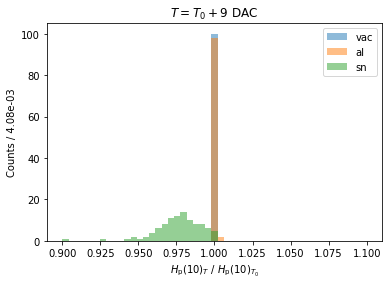

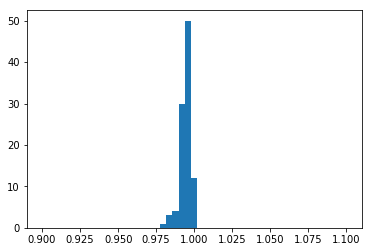

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


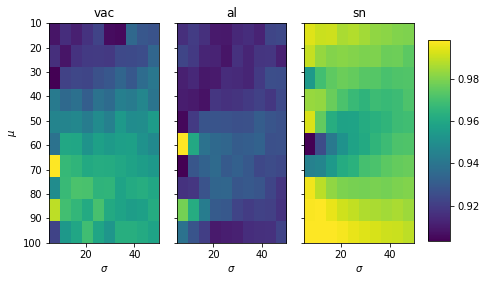

Text(0,0.5,'$\\mu$')

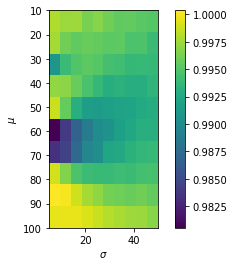

In [9]:
print doseRecList[-1]

# Distributions for each detector
bins = np.linspace(0.9, 1.1, 50)
for i in range(3):
    plt.hist(np.asarray(doseRecList)[:,:,i].flatten(), bins=bins, alpha=.5, label=titles[i])
plt.legend()
plt.xlabel('$H_\mathrm{p}$(10)$_{T}$ / $H_\mathrm{p}$(10)$_{T_0}$')
plt.ylabel('Counts / %.2e' % (bins[1] - bins[0]))
plt.title('$T = T_0' + (' + ' if TAdd > 0 else ' - ') + '%d$ DAC' % TAdd)
plt.show()

# Distribution of total dose
plt.hist(np.asarray(totalDoseRecList).flatten(), bins=bins)
plt.show()

fig, ax = plt.subplots(1, 3, sharey=True)
for i in range(3):
    im = ax[i].imshow(np.asarray(doseRecList)[:,:,i], extent=(5, 50, 100, 10))
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('$\sigma$')
ax[0].set_ylabel('$\mu$')
cbar_ax = fig.add_axes([1., 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()

plt.imshow(totalDoseRecList, extent=(5, 50, 100, 10))
plt.colorbar()
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

# Am-Heating Measurement (DPX22)

In [46]:
import ToTtoEnergy as tte

# measDir = '../../dpx_data/ToTAmHeating_DPX22/' 
measDir = '../../dpx_data/ToTAmHeating_DPX22/'
tempFile = measDir + 'ToTMeasurement_temp.hck'
totFile = measDir + 'ToTMeasurement.hck'
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22.hck')

## AmPlexi Measurement (DPX22)

In [7]:
# Chip was recalibrated!
# measDir = '../../dpx_data/Measurements/DPX22/AmPlexi/'
# tempFile = measDir + 'ToTMeasurement_27_temp.hck'
# totFile = measDir + 'ToTMeasurement_27.hck'
measDir = '../../dpx_data/Measurements/DPX22/AmTestSlot1/'
tempFile = measDir + 'ToTMeasurement_AmTestSlot1_temp.hck'
totFile = measDir + 'ToTMeasurement_AmTestSlot1.hck'
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22_6_109.hck')['Slot1']

In [47]:
# Attention: redefinition of tempDict
tempDict = hickle.load(tempFile)
totDict = hickle.load(totFile)

## Temperature
There might be an issue when fitting the temperature first. Try to use temperature data directly from file


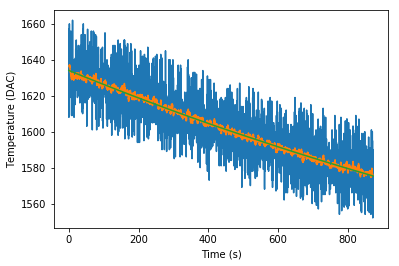

In [48]:
def tempDecay(x, A, T, c):
    return A*np.exp(-x/T) + c

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(tempDict['time'], tempDict['temp'])
# tempFilt = scipy.signal.savgol_filter(tempDict['temp'], 151, 3)

NFilt = 30
tempFilt = running_mean(tempDict['temp'], NFilt)
plt.plot(tempDict['time'][NFilt//2:-NFilt//2+1], tempFilt)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (DAC)')

popt, pcov = scipy.optimize.curve_fit(tempDecay, np.arange(len(tempDict['time'])), tempDict['temp'])
plt.plot(tempDict['time'], tempDecay(np.arange(len(tempDict['time'])), *popt))

In [49]:
def dataToHist(data, discardPixel=[]):
    histDict = {'bins': [], 'hist': []}
    for pixel, d in enumerate(data):
        if pixel in discardPixel:
            histDict['bins'].append(None), histDict['hist'].append(None)
            continue

        d = np.asarray(d)
        d = d[d > 0]
        if len(d) == 0 or len(set(d)) == 1:
            hist, bins = None, None
        else:
            try:
                hist, bins = np.histogram(d, bins=int(max(d) - min(d)))
            except:
                hist, bins = None, None
                pass
        histDict['bins'].append(bins), histDict['hist'].append(hist)
        
    return histDict

## Temperature Correction
Notice that Toffset was corrected with -20.
This needs to be fixed though

In [50]:
data = np.asarray(totDict['Slot1']).T # * 0.88 # - needed for first calibration

data_temp_corr = []
for pixel in range(256):
    print pixel,
    d = data[pixel]
    d = np.ma.array(d, mask=~(d > 0))
    real_d = np.asarray([pttt.getRealToT(d[i], tempDecay(i, *popt), outDict['Toffset'] - 20, slope[pixel], offset[pixel]) for i in range(len(d))])
    data_temp_corr.append( real_d[~np.isnan(real_d)] )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255


In [12]:
fn = hickle.load('../../dpx_data/Measurements/DPX22/AmMo_DPX22_complete.hck')
# fn = hickle.load('../../dpx_data/ToTMeasurement_7_total.hck')
# fn = hickle.load('../../dpx_data/Measurements/DPX6/ToTMeasurementHist_AmSn4.hck')

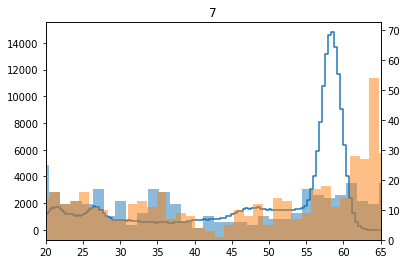

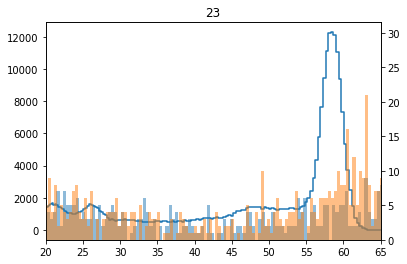

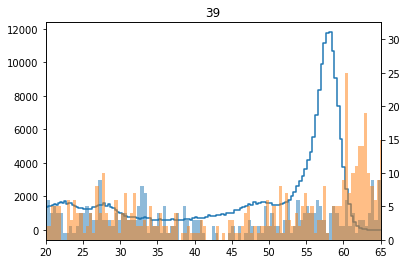

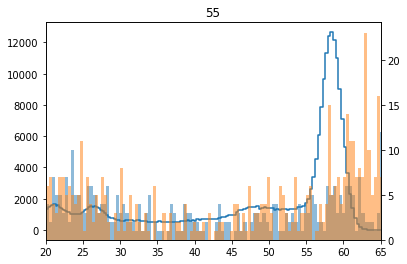

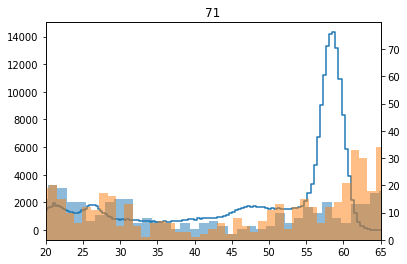

In [ ]:
# idxRange = [8 + i*16 for i in range(13, 16)]
SHOW_ENERGY = True
SHOW_FAC = 1.

idxRange = [7 + i*16 for i in range(16)]
for idx in idxRange:
    # Energy conversion
    p = paramsDict[idx]
    a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
    
    if SHOW_ENERGY:
        fn_bins = tte.ToTtoEnergy(fn['bins'][idx][:-1], a, b, c, t, h, k)
    else:
        fn_bins = fn['bins'][idx][:-1]
    plt.step(fn_bins, fn['hist'][idx], where='post')
    ax = plt.twinx()
    d = np.asarray(totDict['Slot1']).T[idx] # * 0.88 # - needed for first calibration
    len_d = len(d)
    d = np.ma.array(d, mask=~(d > 0))[:int(SHOW_FAC*len_d)]

    # Temperature correction
    real_d = np.asarray([pttt.getRealToT(d[i], tempDecay(i, *popt), outDict['Toffset'] - 22, slope[idx], offset[idx]) for i in range(len(d))])
    len_real_d = len(real_d)
    real_d = real_d[~np.isnan(real_d)][:int(SHOW_FAC*len_real_d)]

    if SHOW_ENERGY:
        real_d_energy = tte.ToTtoEnergy(real_d, a, b, c, t, h, k)
        ax.hist(real_d_energy, bins=150, alpha=.5)
        ax.hist(tte.ToTtoEnergy(d, a, b, c, t, h, k), bins=150, alpha=.5)
    else:
        ax.hist(real_d, bins=150, alpha=.5)
        ax.hist(d, bins=150, alpha=.5)

    # a, b = 0, int(0.1*len(d))# , len(d)
    # real_d = pttt.getRealToT(d[a:b], 1630, 1560, slope[idx], offset[idx])

    plt.title(idx)
    plt.xlim(20, 65)
    plt.show()

[10.08688502 10.45207721 10.54083305 ... 59.29777058 59.29777058
 60.16592868]


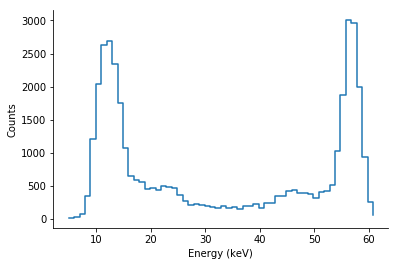

[ 9.9732874  10.36731306 10.45207721 ... 64.98690956 64.98690956
 65.42872042]


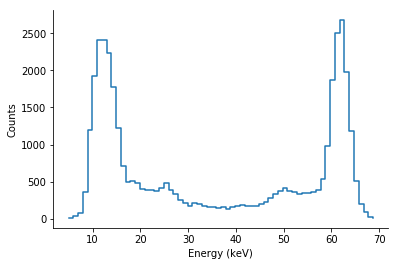

array([ 9.9732874 , 10.36731306, 10.45207721, ..., 64.98690956,
       64.98690956, 65.42872042])

In [45]:
reload(tte)
discardPixel = [] # [28, 29, 30, 106, 199, 243]

histDict = dataToHist(np.asarray(data_temp_corr), discardPixel=discardPixel)
tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=False)

data = np.asarray(np.asarray(totDict['Slot1'])).T # * 0.88
histDict = dataToHist(data, discardPixel=discardPixel)
tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=False)

(256, 300)
[ 9.9732874  10.54083305 11.05458103 ... 64.1049582  64.545652
 64.545652  ]


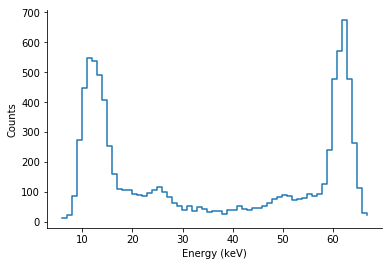

(256, 300)
[10.45207721 10.73140343 10.86908979 ... 64.545652   64.545652
 64.545652  ]


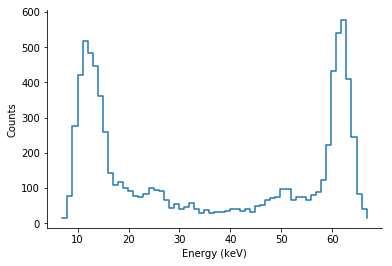

(256, 300)
[10.36731306 10.9049534  11.29918581 ... 62.34803799 62.78636744
 64.545652  ]


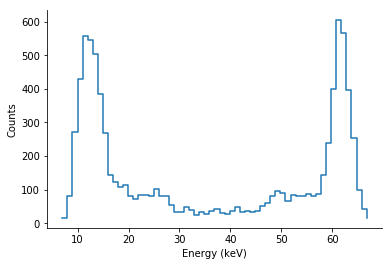

(256, 300)
[10.57135066 10.57135066 10.79911876 ... 62.78636744 63.22530487
 64.1049582 ]


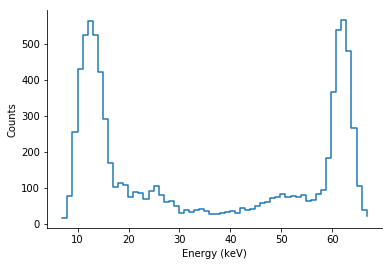

(256, 130)
[11.61949402 12.09723286 12.40057527 ... 61.47325002 62.34803799
 65.42872042]


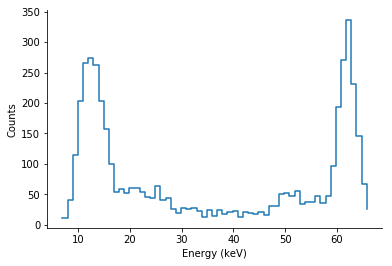

(256, 0)
[]


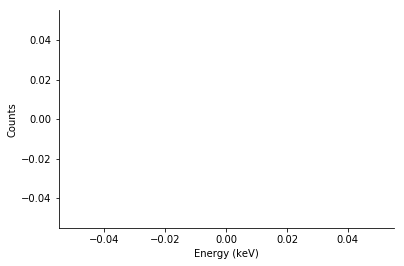

(256, 0)
[]


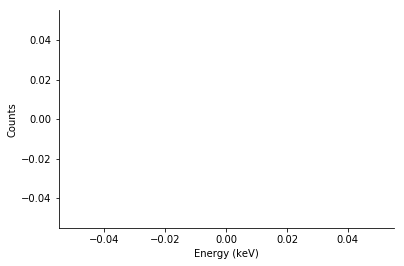

(256, 0)
[]


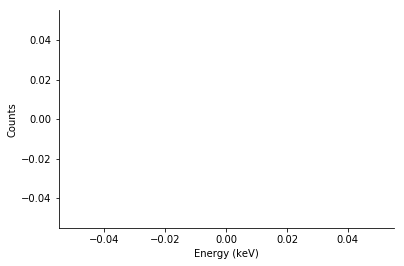

(256, 0)
[]


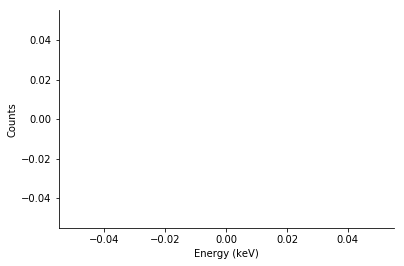

(256, 0)
[]


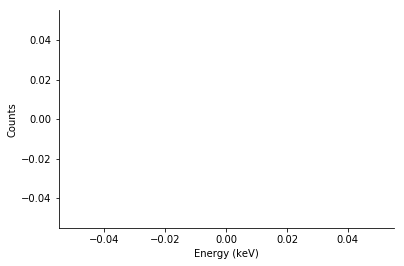

(256, 0)
[]


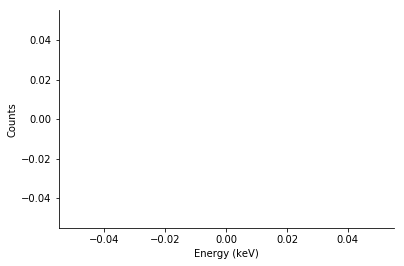

(256, 0)
[]


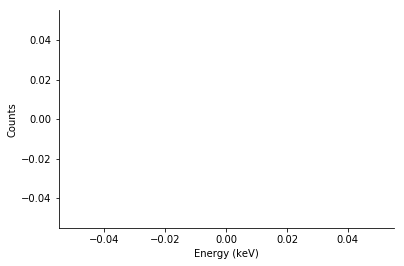

(256, 0)
[]


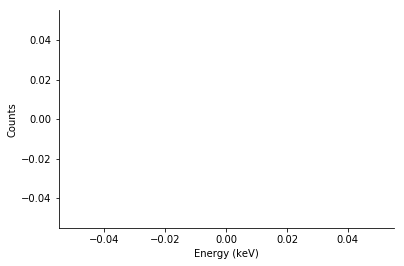

(256, 0)
[]


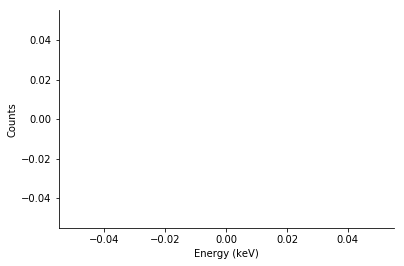

(256, 0)
[]


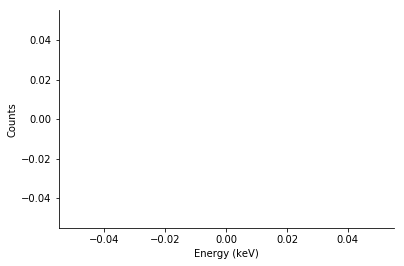

(256, 0)
[]


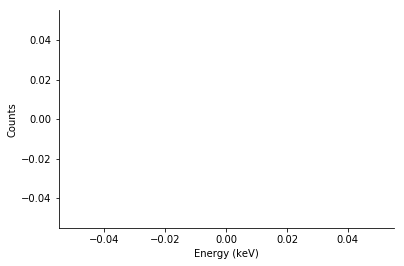

(256, 0)
[]


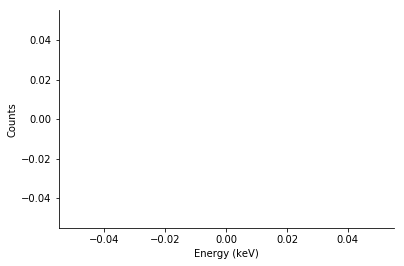

(256, 0)
[]


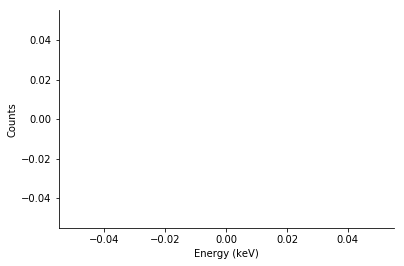

(256, 0)
[]


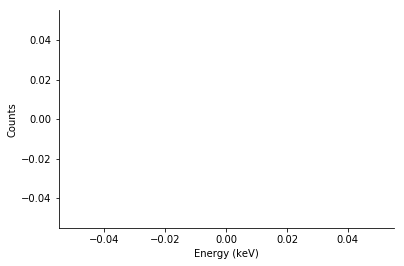

(256, 0)
[]


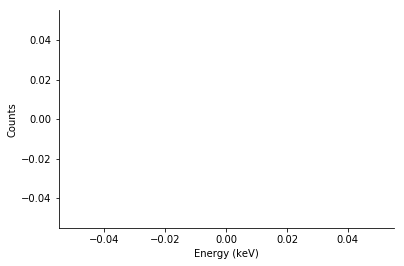

(256, 0)
[]


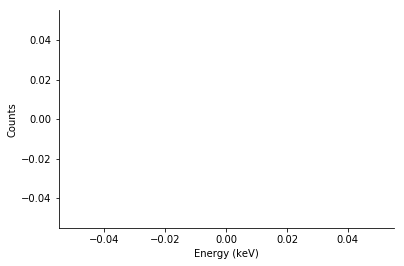

(256, 0)
[]


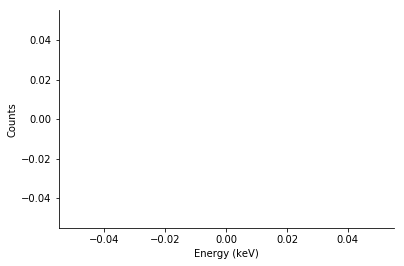

(256, 0)
[]


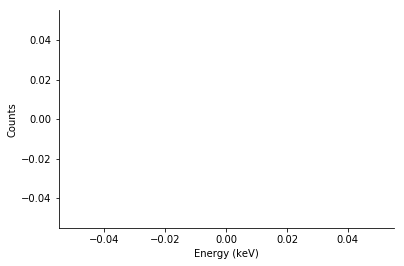

(256, 0)
[]


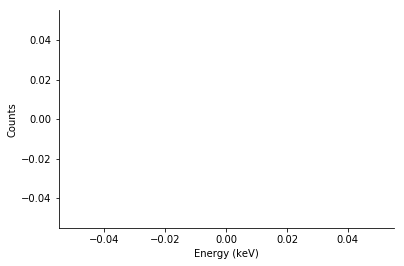

(256, 0)
[]


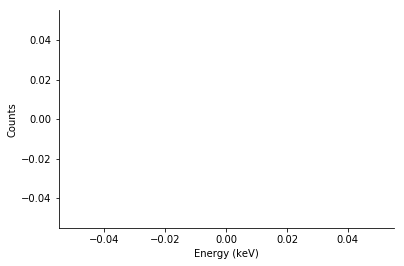

(256, 0)
[]


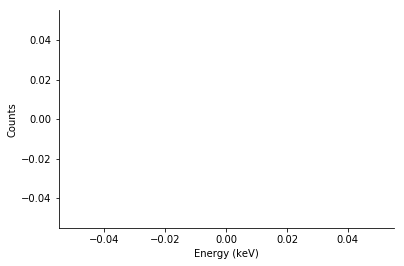

(256, 0)
[]


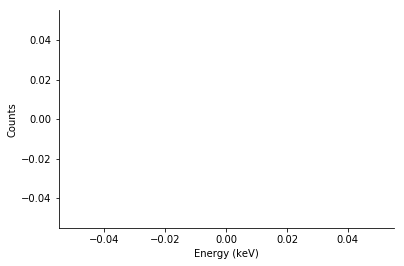

(256, 0)
[]


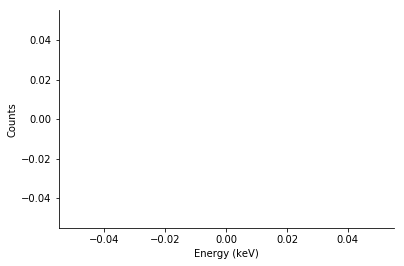

(256, 0)
[]


KeyboardInterrupt: 

In [18]:
reload(tte)
discardPixel = [] # [30, 106, 199, 243]
for i in range(30):
    data = np.asarray( totDict['Slot1'] )[i * 300:(i+1) * 300].T # * 0.88
    print data.shape
    histDict = dataToHist(data, discardPixel=discardPixel)
    tte.getToTtoEnergy(histDict, paramsDict, use_hist=True, plot=False)

## Dose Measurement

In [20]:
# Bin measurement data
data = np.asarray(totDict['Slot1']).T # * 0.88
titles = ['vac', 'al', 'sn']
final_time = int(tempDict['time'][-1]) - 100
time_step = 60

histDict = {}
doseDict, doseCorrDict = {}, {}
for tit_idx, tit in enumerate(titles):
    pixelDict = {}
    pixelDose, pixelCorrDose = [], []
    for pixel in range(256):
        if not pixel in paramsDict.keys():
            continue
        p = paramsDict[pixel]
        a, b, c, t, h, k = p['a'], p['b'], p['c'], p['t'], p['h'], p['k']
        bins_tot = tte.EnergyToToT(np.asarray(binEdgesTh[tit]), a, b, c, t, h, k)
        if not (bins_tot == np.sort(bins_tot)).all():
            continue

        timeDict = {}
        timeDose, timeCorrDose = [], []
        for time in np.arange(0, final_time, time_step):
            time_args = np.argwhere(np.logical_and(tempDict['time'] >= time, tempDict['time'] < time + time_step)).flatten()
            print time_args
            data_time = data[pixel][time_args]
            h = np.histogram(data_time, bins=bins_tot)[0]
            timeDict[time] = h
            
            # Get dose
            dose = np.dot(h, fAlpha[tit_idx](binEdgesTh[tit])[:-1])
            
            # Get corrected dose
            time_idx = np.argmin(np.abs(time - tempDict['time'])), np.argmin(np.abs((time + time_step) - tempDict['time']))
            temperature = tempDecay(time_idx[1], *popt) # 0.5 * np.sum([tempDecay(elm, *popt) for elm in time_idx])
            
            bins_corr_energy = getDataAtTSingle(bins_tot[:-1], temperature, slope[pixel], offset[pixel], outDict['Toffset'], p, energy=True)
            # if tit == 'sn':
            #    print bins_corr_energy
        
            doseCorr = np.dot(h, fAlpha[tit_idx](bins_corr_energy))
            timeDose.append( dose ), timeCorrDose.append( doseCorr )
            
        pixelDict[pixel] = timeDict
        pixelDose.append( timeDose ), pixelCorrDose.append( timeCorrDose )
    histDict[tit] = pixelDict
    doseDict[tit], doseCorrDict[tit] = pixelDose, pixelCorrDose

# getDoseRate(x, y, y_new, titles, Toffset, TAdd, fAlpha, verbose=False, plot=False)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

IndexError: list index out of range

In [21]:
plt.step(binEdgesTh['vac'][:-1], histDict['vac'][8][600], where='post')

KeyError: 'vac'

In [22]:
print sorted( histDict['vac'][4].keys() )
print doseCorrDict['vac'][0], doseCorrDict['vac'][-1]
print doseDict['vac'][0], doseDict['vac'][-1]
print np.count_nonzero(~np.isnan(doseCorrDict['vac']))
print np.count_nonzero(~np.isnan(doseCorrDict['vac']), axis=0)
print np.nansum(doseCorrDict['sn'], axis=0)
plt.plot(np.nansum(doseCorrDict['sn'], axis=0) * 182. / np.count_nonzero(~np.isnan(doseCorrDict['sn']), axis=0))
plt.plot(np.sum(doseDict['sn'], axis=0))

KeyError: 'vac'

Text(0,0.5,'Response')

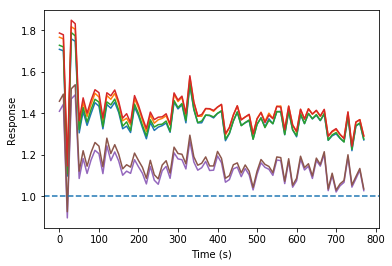

In [301]:
for t in titles:
    doses = np.asarray(doseDict[t])
    doses_corr = np.asarray(doseCorrDict[t]) * 182 / 176
    # plt.imshow(doses_corr)
    # plt.show()
    plt.plot(sorted(histDict[t][6].keys()), np.sum(doses, axis=0)) # / np.sum(doses, axis=0)[0])
    plt.plot(sorted(histDict[t][6].keys()), np.nansum(doses_corr, axis=0)) # / (np.nansum(doses_corr, axis=0)[0]))

plt.axhline(y=1, ls='--')
plt.xlabel('Time (s)')
plt.ylabel('Response')

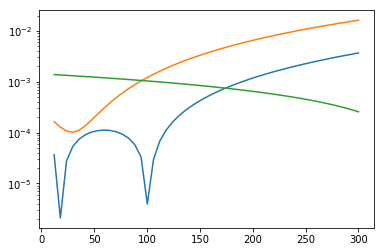

In [210]:
x_show = np.linspace(12, 300)
for i in range(3):
    plt.semilogy(x_show, fAlpha[i](x_show))

## Dose Data

In [25]:
import ipywidgets as widgets

In [26]:
measDir = '../../dpx_data/Measurements/DPX22/'
tempFile = measDir + 'doseMeasurementTemp_AmPlexiLong.hck'
doseFile = measDir + 'doseMeasurement_AmPlexiLong.hck'
paramsDict = hickle.load('../../dpx_data/energyConversion/paramsDict_DPX22_6_109.hck')['Slot1']

In [27]:
tempDict = hickle.load(tempFile)
doseDict = hickle.load(doseFile)

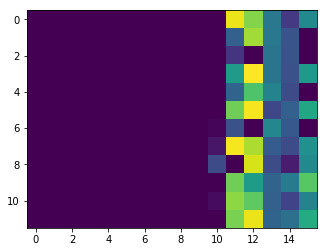

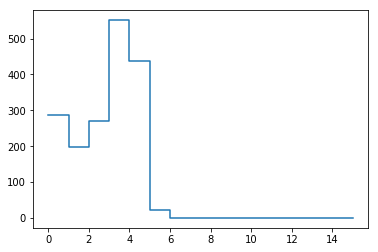

In [28]:
idx = 20
plt.imshow( doseDict['Slot1'][idx][0][2:-2] )
plt.show()
plt.step(np.arange(16), np.flip(np.sum(doseDict['Slot1'][idx][0][2:-2], axis=0), 0), where='post')

In [29]:
def showFrame(doseDict, tempDict, idx=0):
    largePixels = np.asarray([pixel for pixel in np.arange(256) if pixel % 16 not in [0, 1, 14, 15]])
    hist = np.reshape(doseDict[idx], (256, -1))[largePixels]
    plt.step(binEdgesTh['vac'][:-1], np.flip(np.sum(hist, axis=0), axis=0), where='post')
    # ax2 = plt.twinx()
    # ax2.step(binEdgesTh['vac'][:-1], fAlpha[0](binEdgesTh['vac'][:-1]), where='post', color='C2')
    # print np.dot(np.flip(np.sum(hist, axis=0), axis=0), fAlpha[0](binEdgesTh['vac'][:-1]))
    # ax2.set_ylim(0, 1.5e-4)
    
    plt.xlim(12, 100)
    plt.ylim(top=10000)
    plt.title('Frame %d' % idx)
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts per bin')

In [30]:
_ = widgets.interact(showFrame, doseDict=doseDict, tempDict=tempDict, idx=widgets.IntSlider(value=0, min=0, max=len(doseDict['Slot1']) - 1, step=1, interval=500))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnZG9zZURpY3QnLCBvcHRpb25zPXsnU2xvdDEnOiBbYXJyYXkoW1tbIDAuLCAgMC4sICAwLiwgLi4uLCAgMS4sICDigKY=


Text(0,0.5,'Temperature (DAC)')

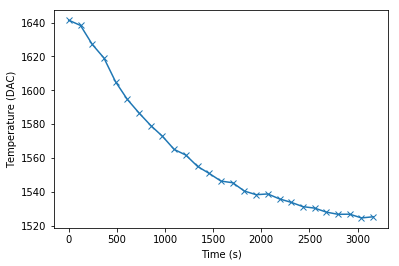

In [31]:
plt.plot(tempDict['time'], tempDict['temp'], marker='x')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (DAC)')

In [40]:
Toffset = outDict['Toffset'] # 1640

titles = ['vac', 'al', 'sn']
max_range = 1

doseRecList = []
doseTotal = 0
doseFrameList, doseRecFrameList = [], []
for frame in range(len(doseDict['Slot%d' % max_range])):
    for i in range(max_range):
        title = 'Slot%d' % i
        x = binEdgesTh[titles[i-1]]
        alpha = fAlpha[i](binEdgesTh[titles[i]][:-1])
        doseData = np.flip(np.reshape(doseDict['Slot%d' % (i + 1)][frame], (256, -1)), axis=1)

        doseSingleList, doseRecSingleList = [], []
        for pixel in range(256):
            if pixel not in paramsDict.keys():
                continue

            y = doseData[pixel]
            p = paramsDict[pixel]
            
            # Get uncorrected dose
            mean, std = histMean(x, doseData[pixel])
            # print 'Prior:', mean, std
            dose = np.dot(y, alpha)
            
            # Transfer back to T0
            xToT = tte.EnergyToToT(x, p['a'], p['b'], p['c'], p['t'], p['h'], p['k'])
            T = (np.diff(tempDict['temp']) + tempDict['temp'][:-1])[frame]
            x_new = getDataAtTSingle(xToT, T, slope[pixel], offset[pixel], Toffset, paramsDict[pixel], energy=True)
            mean_rec, std_rec = histMean(x_new, y)
            # print 'After:', mean_rec, std_rec

            alpha_rec = fAlpha[i](x_new[:-1])
            doseRec = np.dot(y, alpha_rec)
            # totalDoseRec += doseRec

            doseRecList.append( doseRec / dose )
            
            doseSingleList.append( dose )
            doseRecSingleList.append( doseRec )
        
        # Get rid of outliers
        doseFrame, doseRecFrame = np.median(doseSingleList) * 256, np.median(doseRecSingleList) * 256 # np.sum(doseSingleList), np.sum(doseRecSingleList)
        doseFrameList.append( doseFrame ), doseRecFrameList.append( doseRecFrame )

[3.02084820759642, 3.103877926548145, 3.1450993791381223, 3.0911192385607364, 3.078550709809482, 2.970383128826612, 2.546663028895594, 2.303131324048663, 2.3260084531369154, 2.2537395844616803, 2.228881222012279, 2.127920247712858, 2.010186616930407, 1.8211931477619587, 1.6325206278390498, 1.4853792364707907, 1.4938361489080612, 1.4542118681831044, 1.4393402122471395, 1.426040657234362, 1.3585133451948388, 1.3717514564173636, 1.2519921438549284, 1.2836425844935107, 1.353425428583952, 1.3253560515644836]
[3.2526409903537, 3.016054758415166, 2.8873182983007593, 2.920959098342481, 3.116913111823554, 3.217902242379843, 2.8692097128579825, 2.7265576191704115, 2.8806432952889924, 3.049520448699468, 3.3827907990186636, 3.3490944661157807, 3.343762647828391, 3.167189825743301, 3.1061908555655804, 2.718191235377164, 2.836166593847028, 2.764819278610581, 2.9832378217075544, 3.052018832490803, 3.0333903427413658, 3.1483193123327395, 3.0283249665298975, 3.057928770534526, 3.2407966795602285, 3.270

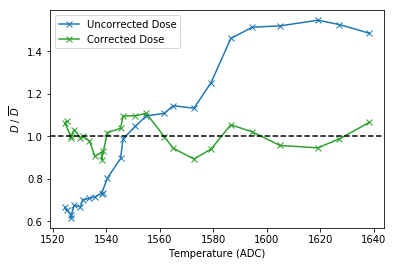

In [41]:
t = (tempDict['temp'][:-1] + np.diff(tempDict['temp']))
plt.plot(t, doseFrameList / np.mean(doseFrameList), marker='x', label='Uncorrected Dose')
plt.plot(t, doseRecFrameList / np.mean(doseRecFrameList), marker='x', label='Corrected Dose', color='C2')
plt.legend()
plt.axhline(y=1, ls='--', color='k')
plt.xlabel('Temperature (ADC)')
plt.ylabel(r'$D$ / $\overline{D}$')

print doseFrameList
print doseRecFrameList